In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tsf.windows import *
sns.set()
plt.rcParams['figure.dpi'] = 150

/anaconda3/envs/cryptocurr/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Transformación a serie categórica atendiendo a cambios porcentuales

In [4]:
# Raw data
BTC = pd.read_csv('../data/bitcoin.csv', index_col='Date', parse_dates=True)
BTC_train = pd.read_csv('../data/bitcoin_train.csv', index_col='Date', parse_dates=True)
BTC_test  = pd.read_csv('../data/bitcoin_test.csv', index_col='Date', parse_dates=True)

ETH = pd.read_csv('../data/ethereum.csv', index_col='Date', parse_dates=True)
ETH_train = pd.read_csv('../data/ethereum_train.csv', index_col='Date', parse_dates=True)
ETH_test  = pd.read_csv('../data/ethereum_test.csv', index_col='Date', parse_dates=True)

# Series
BTC_serie = BTC[['Adj Close']]
BTC_train_serie = BTC_train[['Adj Close']]
BTC_test_serie = BTC_test[['Adj Close']]

ETH_serie = ETH[['Adj Close']]
ETH_train_serie = ETH_train[['Adj Close']]
ETH_test_serie = ETH_test[['Adj Close']]

# Datetime indexs
BTC_index = BTC.index
BTC_train_index = BTC_train.index
BTC_test_index = BTC_test.index

ETH_index = ETH.index
ETH_train_index = ETH_train.index
ETH_test_index = ETH_test.index

In [5]:
# Discretization function
# Discretization
# Class -2 -> Hard bearish: < -5%
# Class -1 -> Bearish: -5% < value =< -1%
# Class 0 -> Hold: -1% < value < 1%
# Class 1 -> Bullish: 1% >= value > 5%
# Class 2 -> Hard bullish: > 5%

def simple_discretization(serie):
    new_serie = np.copy(serie)
    
    low_bearish = -5
    top_bearish = -1
    low_bullish = 1
    top_bullish = 5
    
    
    new_serie[serie < low_bearish] = 0
    new_serie[(serie >= low_bearish) & (serie <= top_bearish)] = 1
    new_serie[(serie > top_bearish) & (serie < low_bullish)] = 2
    new_serie[(serie >= low_bullish) & (serie <= top_bullish)] = 3
    new_serie[serie > top_bullish] = 4
    
    return new_serie.astype('int')

In [6]:
# Bitcoin percentage change serie
BTC_raw = BTC_serie.values.flatten()

BTC_pct_variation_serie = [((BTC_raw[i] - BTC_raw[i-1]) / BTC_raw[i-1]) * 100 for i in range(1,len(BTC_raw))]
BTC_pct_variation_serie = np.insert(BTC_pct_variation_serie, 0, 0)

# Ethereum percentage change serie
ETH_raw = ETH_serie.values.flatten()

ETH_pct_variation_serie = [((ETH_raw[i] - ETH_raw[i-1]) / ETH_raw[i-1]) * 100 for i in range(1,len(ETH_raw))]
ETH_pct_variation_serie = np.insert(ETH_pct_variation_serie, 0, 0)

## Variación de precio Bitcoin

/anaconda3/envs/cryptocurr/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


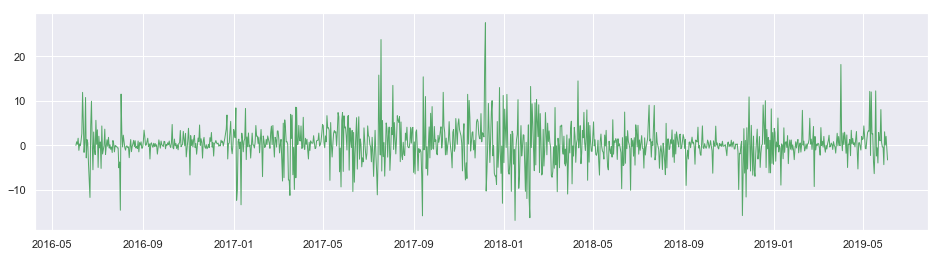

In [7]:
plt.figure(figsize=(16, 4))
plt.plot(BTC_index, BTC_pct_variation_serie, color='g', linewidth=1)
plt.show()

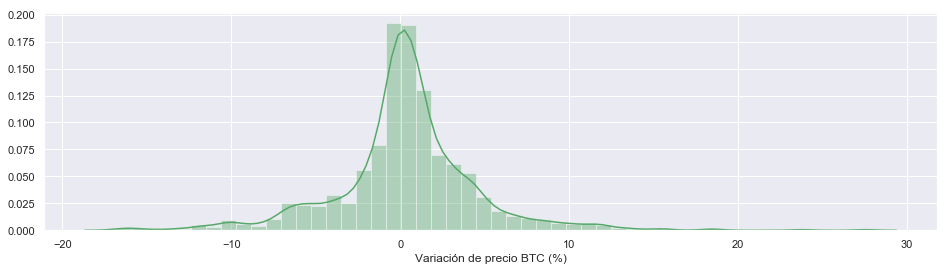

In [8]:
# Histogram
plt.figure(figsize=(16, 4))
sns.distplot(BTC_pct_variation_serie, axlabel='Variación de precio BTC (%)', color='g');

In [9]:
# Discretization
BTC_pct_variation_disc = simple_discretization(BTC_pct_variation_serie)


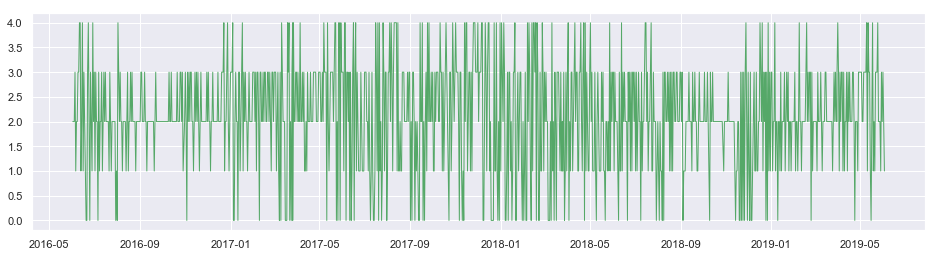

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(BTC_index, BTC_pct_variation_disc, color='g', linewidth=1)
plt.show()

## Variación de precio Ethereum

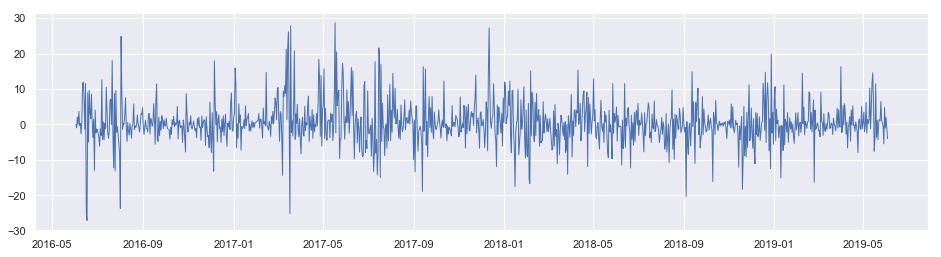

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(ETH_index, ETH_pct_variation_serie, color='b', linewidth=1)
plt.show()

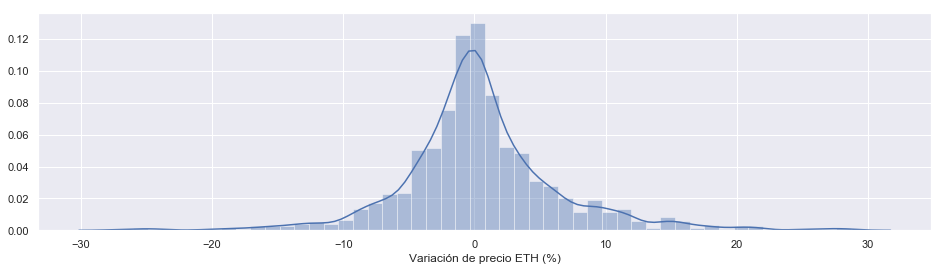

In [12]:
# Histogram
plt.figure(figsize=(16, 4))
sns.distplot(ETH_pct_variation_serie, axlabel='Variación de precio ETH (%)', color='b');

In [13]:
# Discretization
ETH_pct_variation_disc = simple_discretization(ETH_pct_variation_serie)

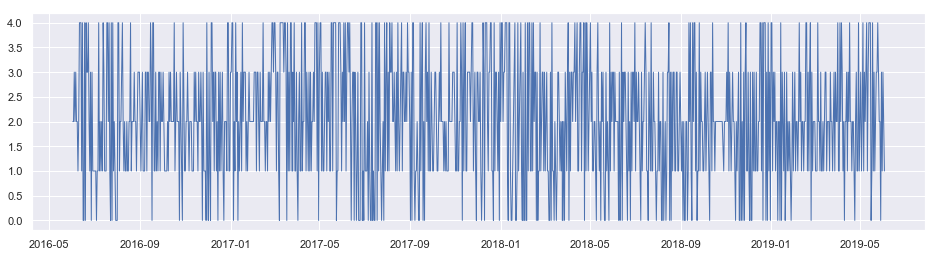

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(ETH_index, ETH_pct_variation_disc, color='b', linewidth=1)
plt.show()

## Proporción de clases

[]

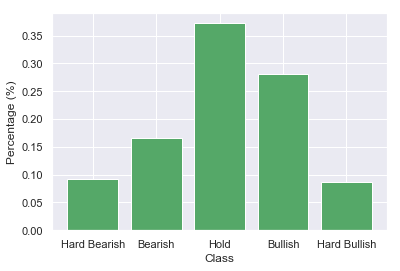

In [20]:
# Balance pct for BTC
class_pct_BTC = [np.sum(BTC_pct_variation_disc == i) / len(BTC_pct_variation_disc) for i in range(0, 5)]

plt.bar(np.arange(5), class_pct_BTC, color='g')
plt.xticks(np.arange(5), ('Hard Bearish', 'Bearish', 'Hold', 'Bullish', 'Hard Bullish'))
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.plot()

[]

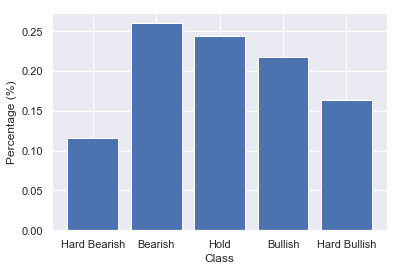

In [19]:
# Balance pct for ETH
class_pct_ETH = [np.sum(ETH_pct_variation_disc == i) / len(ETH_pct_variation_disc) for i in range(0, 5)]

plt.bar(np.arange(5), class_pct_ETH)
plt.xticks(np.arange(5), ('Hard Bearish', 'Bearish', 'Hold', 'Bullish', 'Hard Bullish'))
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.plot()

## Matriz de p instantes anteriores

In [21]:
p = 15
ar = SimpleAR(p)

# ETH
BTC_inputs  = ar.transform(X=[], y=BTC_pct_variation_disc)
BTC_outputs = ar.offset_y(X=BTC_inputs, y=BTC_pct_variation_disc)

# BTC
ETH_inputs  = ar.transform(X=[], y=ETH_pct_variation_disc)
ETH_outputs = ar.offset_y(X=ETH_inputs, y=ETH_pct_variation_disc)


In [22]:
# Save matrixs
np.savetxt('../data/ordinal/BTC_ARinputs_p15.csv', BTC_inputs, fmt='%i')
np.savetxt('../data/ordinal/BTC_ARoutputs_p15.csv', BTC_outputs, fmt='%i')

np.savetxt('../data/ordinal/ETH_ARinputs_p15.csv', ETH_inputs, fmt='%i')
np.savetxt('../data/ordinal/ETH_ARoutputs_p15.csv', ETH_outputs, fmt='%i')